# PyCC Models Client API Tutorial

*Authors: Enze Chen, Eddie Kim*

**Note**: The `ModelsClient` will likely be deprecated in a future version of PyCC in favor of the [`DataViewsClient`](data_views_api_tutorial.ipynb). This tutorial is still helpful in the meantime, and for future reference.

In this notebook, we will cover how to use the `ModelsClient` to interface with *existing* data views and ML models through the [Citrination API](http://citrineinformatics.github.io/python-citrination-client/). We will demonstrate how analyze ML models and leverage them for prediction and design using the [Band gaps from Strehlow and Cook](https://citrination.com/datasets/1160/show_search?searchMatchOption=fuzzyMatch) dataset, where we will have created a model mapping:

$$\text{Chemical formula (inorganic) + Crystallinity (categorical)} \longrightarrow \text{Band gap (real)}$$

## Table of contents
1. [Learning outcomes](#Learning-outcomes)
1. [Data view](#Interface-with-data-views)
1. [t-SNE](#t-SNE)
1. [Predict](#Predict)
1. [Design](#Design)
1. [Additional resources](#Additional-resources)

## Learning outcomes
By the end of this tutorial, you will know how to use the `ModelsClient` to:
* Interface with data views.
* Make predictions on new data with trained ML models.
* Set design parameters and submit design jobs.

## Background knowledge
In order to get the most out of this tutorial, you should already be familiar with the following:
* Create and access datasets through the API ([documentation](http://citrineinformatics.github.io/python-citrination-client/tutorial/data_examples.html) and [tutorial](1_data_client_api_tutorial.ipynb)).
* Create and access data views through the [API](2_data_views_api_tutorial.ipynb) and [UI](../web_ui_examples/03_data_views.md).
* What the data views [front-end UI](https://citrination.com/data_views) looks like, including Predict and Design endpoints.

## Imports

In [1]:
# Standard packages
import json
import os
import time
import uuid # generating random IDs

# Third-party packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

from citrination_client import *
from citrination_client.models.design import Target

## Interface with data views
We will start by initializing the `ModelsClient` from the `CitrinationClient` and look at some basic properties of the view using `get_data_view()`. The returned `DataView` object has the following properties:
* `id`: The view ID.
* `name`: The name of the view.
* `description`: The description of the view.
* `datasets`: A list of datasets used in the view.
* `column_names`: A list of column names in the view.
* `columns`: A list of columns in the view (objects extend [`BaseColumn`](https://github.com/CitrineInformatics/python-citrination-client/tree/master/citrination_client/models/columns)).

In [ ]:
# Instantiate the base CitrinationClient
client = CitrinationClient(os.environ['CITRINATION_API_KEY'], 'https://citrination.com')

# Instantiate the ModelsClient
models_client = client.models

# Look up the data view ID and analyze the view
view_id = 8001
data_view = models_client.get_data_view(view_id)
print('Data view name: {}'.format(data_view.name))
print('Data view description: {}'.format(data_view.description))
print('Names of included datasets: {}'.format([data_view.datasets[i].name for i in range(len(data_view.datasets))]))

You can check on the various services in your view, which includes `predict`, `experimental_design`, `data_reports`, `model_reports`, using `get_data_view_service_status()`. A `ServiceStatus` object has the following properties:
* `ready`: A Boolean indicating whether or not the service can be used.
* `context`: A contextual description of the current status: `notice`, `success`, `error`.
* `reason`: A full sentence explanation of the service's status.
* `event`: An event object describing the current state of the service's progress toward readiness.

If you update the underlying dataset, you can also trigger model `retrain()` through the API.

In [ ]:
# Retrain your models
models_client.retrain(view_id)

# Check status of services in a loop
model_reports_generating = True
time.sleep(10)
while (model_reports_generating):
    view_status = models_client.get_data_view_service_status(view_id)
    model_report_progress = view_status.model_reports.event.normalized_progress
    print('Model reports are still being generated, progress: {0:.1f}%.'.format(100 * model_report_progress))
    if (model_report_progress < 0.99):
        time.sleep(20)
    else:
        print('Model reports generated!')
        model_reports_generating = False

If you are an Admin on your Citrination site, the latest version of the ML template in the view can be obtained using `template_latest_version()`, which takes in the path of the model. 

In [ ]:
template_path = 'view_ml_' + str(view_id) + '_1'
template_version = models_client.template_latest_version(template_path)
print('The ML template is version {}.'.format(template_version))

## t-SNE
t-SNE is short for t-Distributed Stochastic Neighbor Embedding. This technique was developed about [a decade ago](https://lvdmaaten.github.io/tsne/) ([simpler explanation](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)) and it's a powerful projection tool because nearby points in high dimensional space remain close in 2D while distant points remain far apart. Therefore, t-SNE plots are helpful for identifying clusters and structures in your data. We employ t-SNE as a *dimensionality reduction* technique to project the data onto 2 dimensions for ease of visualization.

A `Tsne` object contains many `Projection` objects (one for each output `Property`) with the following properties:
* `xs`: A list of $x$ values of the projection.
* `ys`: A list of $y$ values of the projection.
* `responses`: A list of $z$ (Property) values of the projection.
* `tags`: A list of tags for the projected points.
* `uids`: A list of record UIDs for the projected points.

You can create the t-SNE plot from the coordinates and values. Further analysis with t-SNE is performed in [this other demo](https://github.com/CitrineInformatics/learn-citrination/blob/master/tsneDemo.ipynb).

Highest band gap material: 	Single crystalline, Li1F1, 12.0.
It has projected coordinates: 	(846.157, 255.204).


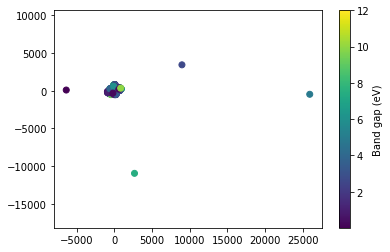

In [3]:
# Get the Tsne object
tsne = models_client.tsne(view_id)
projection_key = list(tsne.projections())[0] # Get first output Property in dict_keys object
projection = tsne.get_projection(projection_key)
max_index, max_value = (np.argmax(projection.responses), max(projection.responses))
print('Highest band gap material: \t{0}.'.format(projection.tags[max_index]))
print('It has projected coordinates: \t({0:.3f}, {1:.3f}).'.format(projection.xs[max_index], projection.ys[max_index]))
plt.figure()
ax = plt.gca()
plt.scatter(projection.xs, projection.ys, c=projection.responses)
ax.set_aspect(aspect='equal', adjustable='datalim')
plt.colorbar(label='Band gap (eV)')
plt.show()

## Predict
Once ML models have been trained, you can use them to make predictions on new materials. We access the predict endpoint through the `predict()` function, which takes as inputs:
* `data_view_id`: The view ID.
* `candidates`: A list of candidates (dicts) to make predictions on.
* `method`: A string, `scalar` or `from_distribution`, indicating the method for propagating predictions.
* `use_prior`: Boolean indicating whether to apply prior values implied by the property descriptors.

It returns a list of `PredictionResult` objects, from which you can see `all_keys()` (list of strings) or `get_value()`, which returns a `PredictedValue` object given an input key. `PredictedValue` objects have the following properties:
* `key`: The descriptor key for the prediction.
* `value`: The predicted value.
* `loss`: The loss for the prediction (uncertainty).

In [ ]:
# Candidates to submit predictions for
candidates = [{'formula':'MgO', 'Property Crystallinity':'Single crystalline'}, {'formula':'GaN', 'Property Crystallinity':'Single crystalline'}]

# Predict endpoint
prediction_results = models_client.predict(view_id, candidates)
prediction_keys = list(prediction_results[0].all_keys()) # convert dict_keys to list
target_prop = projection_key
index = prediction_keys.index(target_prop)

# Get predicted value
prediction_value = prediction_results[0].get_value(prediction_keys[index])
print('{0} has a predicted value of {1:.3f} +/- {2:.3f}.'.format(prediction_value.key, prediction_value.value, prediction_value.loss))

## Design
Once ML models have been trained, you can generate a list of candidate materials designed to achieve your target objectives. We can submit a new experimental design run using `submit_design_run()`, which takes as inputs:
* `data_view_id`: The view ID.
* `num_candidates`: The number of candidates to return.
* `effort`: A value $\le 30$ indicating how much resource (time) to allocate towards design.
* `target`: A [`Target`](https://github.com/CitrineInformatics/python-citrination-client/blob/master/citrination_client/models/design/target.py) instance, which consists of the name of the output column and the objective (`Max` or `Min`).
* `constraints`: A list of [design constraints](https://github.com/CitrineInformatics/python-citrination-client/tree/master/citrination_client/models/design/constraints) that extend the `BaseConstraint` class.
* `sampler`: The name of the sampler to use as a string, either `Default` or `This view`.

The function returns a `DesignRun` object whose only property is a `uuid`. Depending on the `effort`, this step can take a while.

In [ ]:
# Submit the design run and obtain design run uuid
design_run = models_client.submit_design_run(
    data_view_id=view_id,
    num_candidates=10,
    effort=5,
    target=Target(name=target_prop, objective='Max'),
    constraints=[],
    sampler='Default')

design_id = design_run.uuid

### Design status
With the view ID and design run UUID, we can call `get_design_run_status()` to return a `ProcessStatus()` object with the following properties:
* `uuid`: The UUID of the design run.
* `result`: The result of the design process.
* `progress`: The progress of the process as a percentage.
* `status`: The status string of the process, which can be `Accepted`, `Finished`, or `Killed`.
* `messages`: A list of messages representing the steps the process has already progressed through.

If a design run is taking too long, you can end it with `kill_design_run()`.

In [ ]:
# Check status of design in a loop
design_running = True
while (design_running):
    process_status = models_client.get_design_run_status(view_id, design_id)
    design_status = process_status.status
    print('Design is running, progress: {0:.1f}%.'.format(process_status.progress))
    if (design_status != 'Finished'):
        time.sleep(30)
    else:
        print('Design complete!')
        design_running = False
        
# models_client.kill_design_run(view_id, design_id)

### Design results
With the view ID and design run UUID, we can call `get_design_run_results()` to return a `DesignResults` object with the following properties:
* `best_materials`: An array of candidate dictionaries with maximum expected improvement (MEI) for the target property. These materials are likely to perform the best based on the current model's predictions.
* `next_experiments`: An array of candidate dictionaries with maximum likelihood of improvement (MLI) for the target property. Data from experiments with these materials will be most useful in improving the quality of the model.

For more context, see the [paper by Ling et al. 2017](https://link.springer.com/article/10.1007/s40192-017-0098-z).

In [ ]:
design_results = models_client.get_design_run_results(view_id, design_id)
best_material = design_results.best_materials[0]
print('The best material is {0} with a predicted target value of {1}.'.format(best_material['descriptor_values']['formula'], best_material['descriptor_values'][target_prop]))

## Conclusion
To recap, this notebook demonstrated the functionalities enabled by the `ModelsClient`, which means you can use the API to:
* Interface with an existing data view that already has ML configured.
* Query t-SNE and Predict endpoints for data visualization and making predictions on new materials.
* Submit design runs and generate optimized material candidates.

## Additional resources
It's now possible to conduct the major aspects of the Citrination workflow through the API, which should increase the speed and flexibility of informatics approaches. Some other topics that might interest you include:
* [Sequential learning tutorial](4_sequential_learning_api_tutorial.ipynb) - This tutorial uses toy data to demonstrate an end-to-end [sequential learning pipeline](https://citrine.io/platform/sequential-learning/) using the Citrination API.
* [DataClient](http://citrineinformatics.github.io/python-citrination-client/tutorial/data_examples.html) - This allows you to create datasets and upload PIF data (only) using the API.
  * There is also a corresponding [tutorial](1_data_client_api_tutorial.ipynb).
* [DataViewsClient](https://github.com/CitrineInformatics/python-citrination-client/tree/develop/citrination_client/views) - This allows you to build views (i.e. train ML models) using the API.
  * There is also a corresponding [tutorial](2_data_views_api_tutorial.ipynb).